In [1]:
import scanpy as sc
import anndata
import os
import fnmatch
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
#import scrublet as scr
import importlib
import sys
from harmony import harmonize
import seaborn as sns
from matplotlib import rcParams
import math
from scipy import stats
import seaborn as sns
import scipy as sp
import h5py
import warnings
import random
import math
import scvelo as scv
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

In [2]:
#Setting Scanpy figure parameters 
sc.settings.set_figure_params(dpi = 500, color_map = 'RdPu', dpi_save = 500)

In [4]:
adata_allcells = sc.read_h5ad("./Scanpy_H5AD/adata_CellBender_Scrublet_Srubed_for_publication.h5ad")
adata_allcells

AnnData object with n_obs × n_vars = 122621 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
adata = sc.AnnData(adata_allcells.raw.X, obs=adata_allcells.obs, var=adata_allcells.raw.var, uns=adata_allcells.uns)
adata = adata[adata.obs['leiden_lab_orig'].isin(['Neutrophils']), :]
adata

View of AnnData object with n_obs × n_vars = 6840 × 26030
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig'
    var: 'n_cells', 'Blacklist_Genes'
    uns: 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

In [7]:
adata.raw = adata.copy()
# keep blacklist genes from vars (they are stored in .raw so still accessible)
adata = adata[:,~adata.var['Blacklist_Genes']]
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata.var['highly_variable'].value_counts()
adata

AnnData object with n_obs × n_vars = 6840 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

In [ ]:
sc.tl.pca(adata, svd_solver = 'arpack', random_state = 18,use_highly_variable=True)
sc.pl.pca(adata, components=['1,2', '3,4'], color=['Group',"CD3D",'CD8A',"SFTPB","AGER","DCN","CSF1R"],
          ncols=4, use_raw=True)
sc.pl.pca_loadings(adata, components=[1,2,3,4])
sc.pl.pca_variance_ratio(adata, log=True)

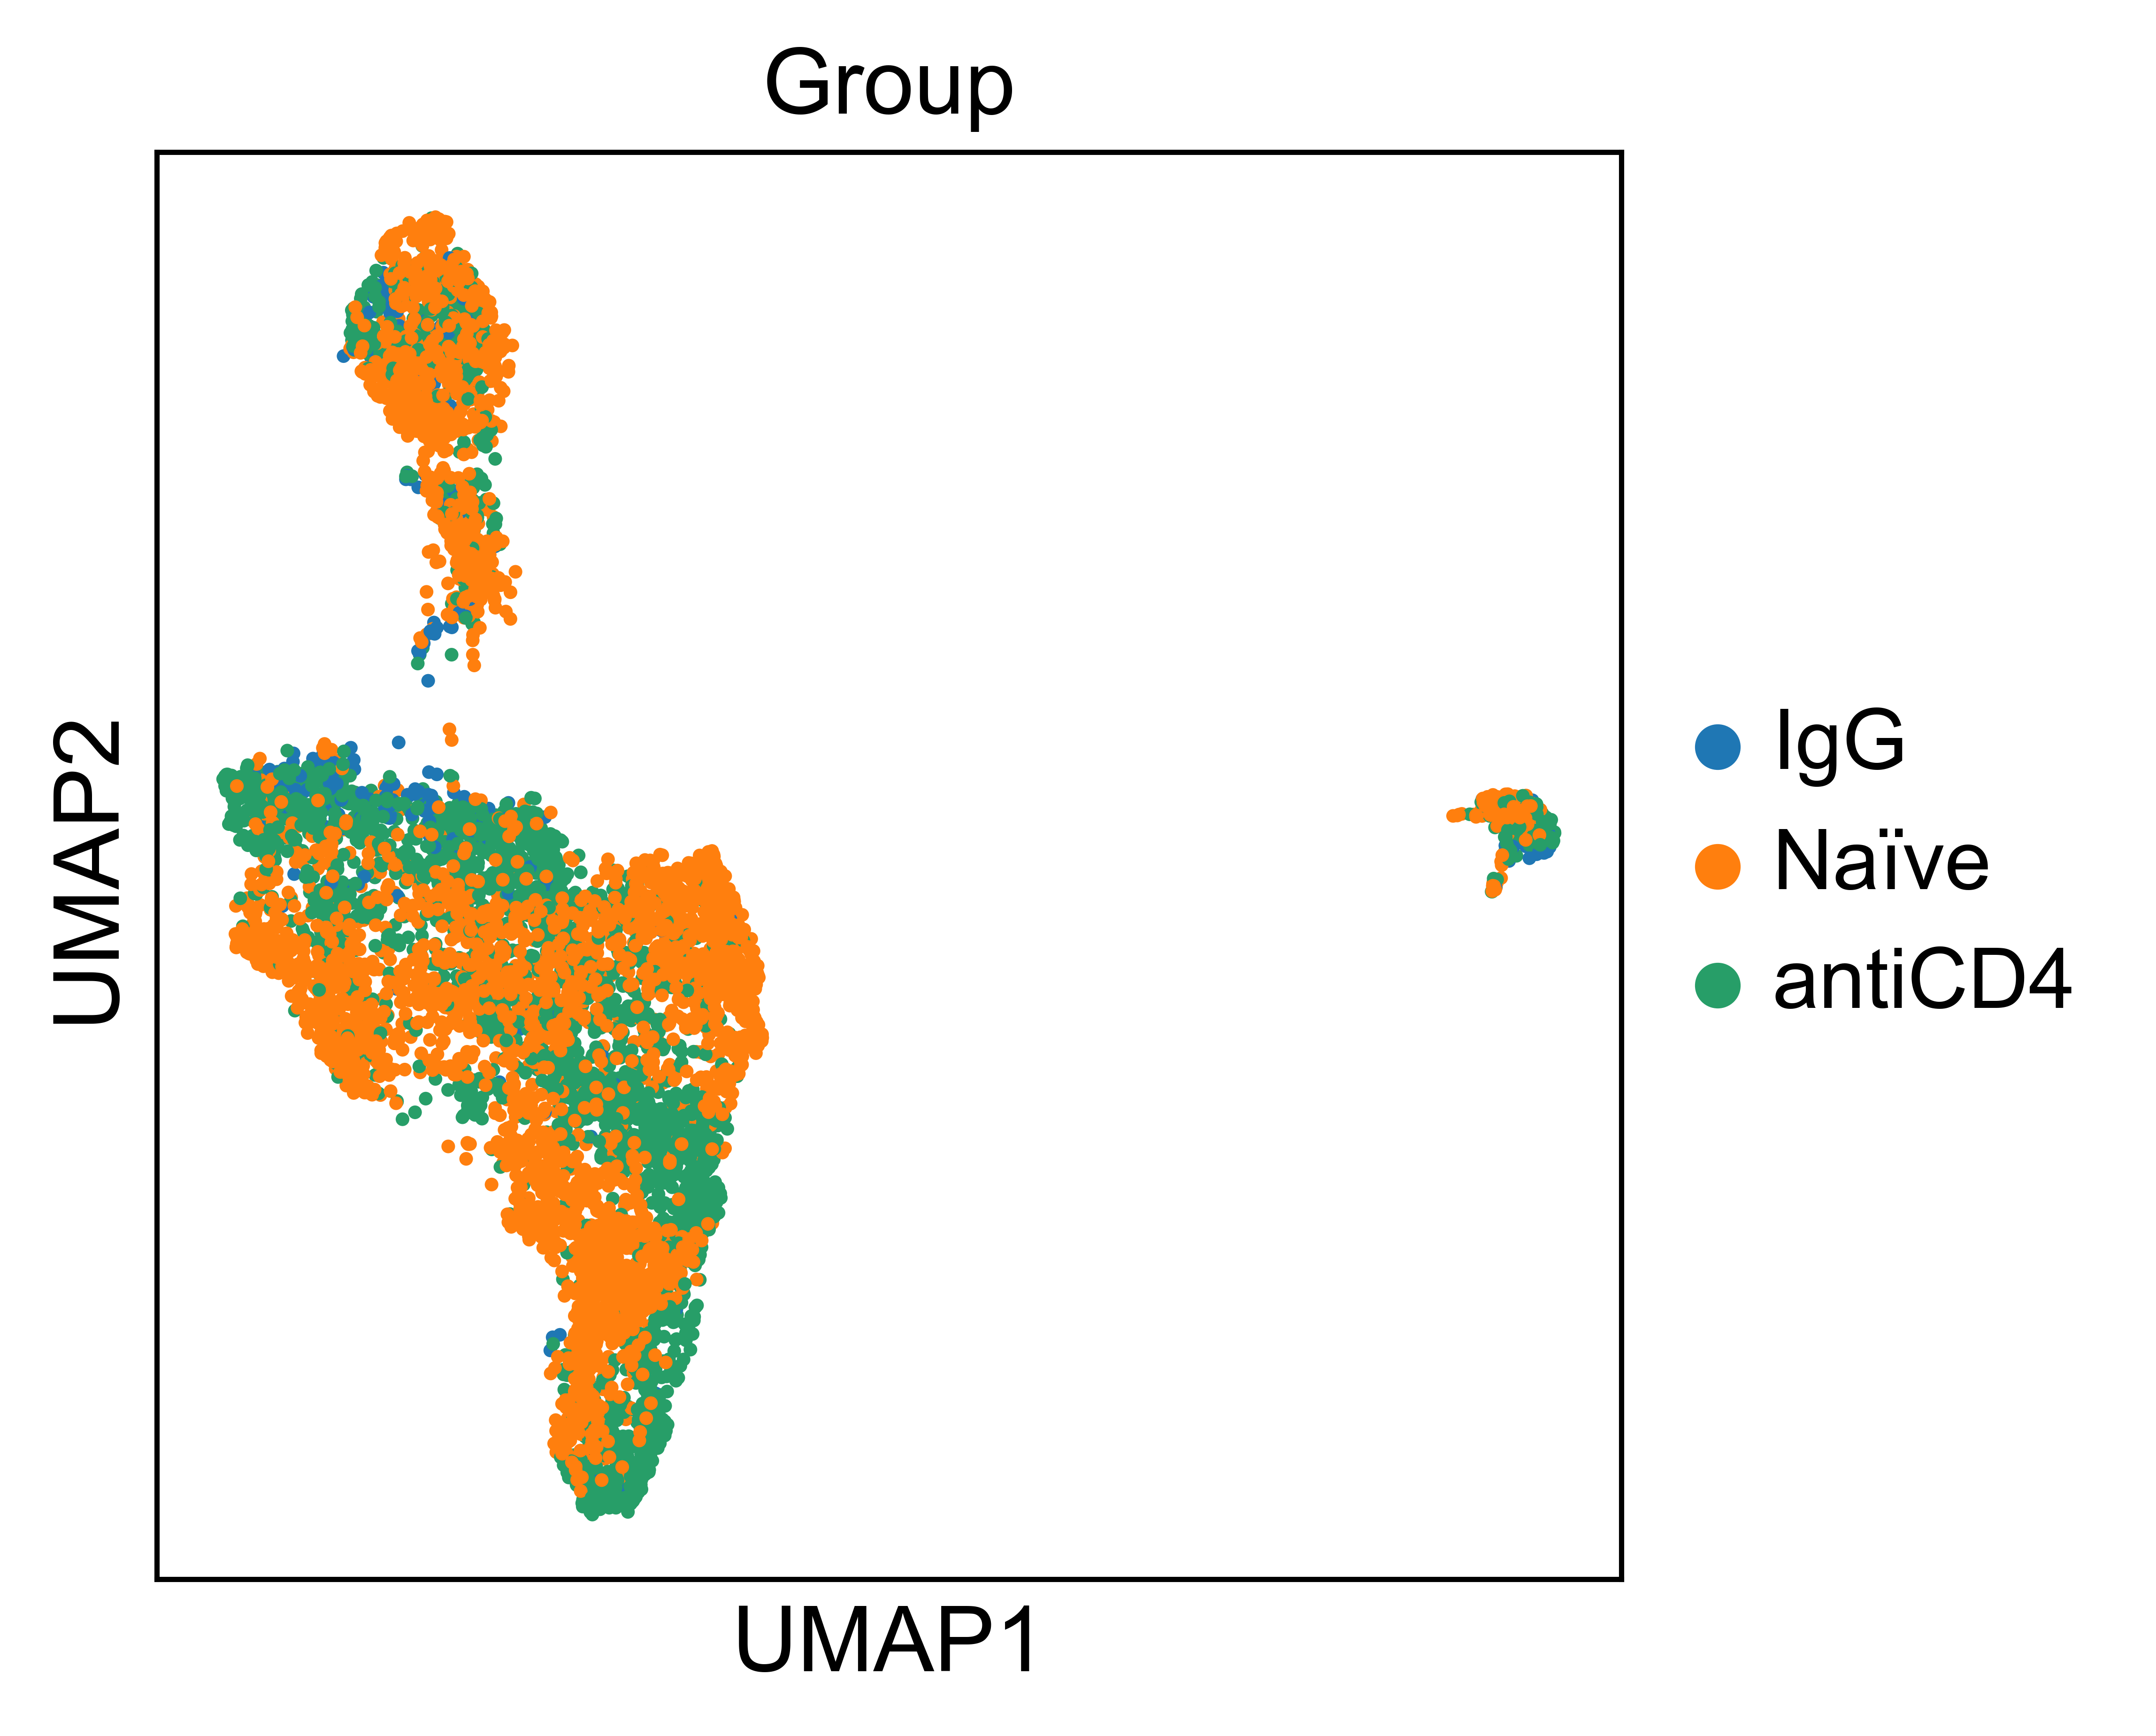

In [9]:
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=12, random_state = 18)
sc.tl.umap(adata, min_dist = 0.1, spread = 2, random_state = 18)
sc.pl.umap(adata, color = ["Group"])

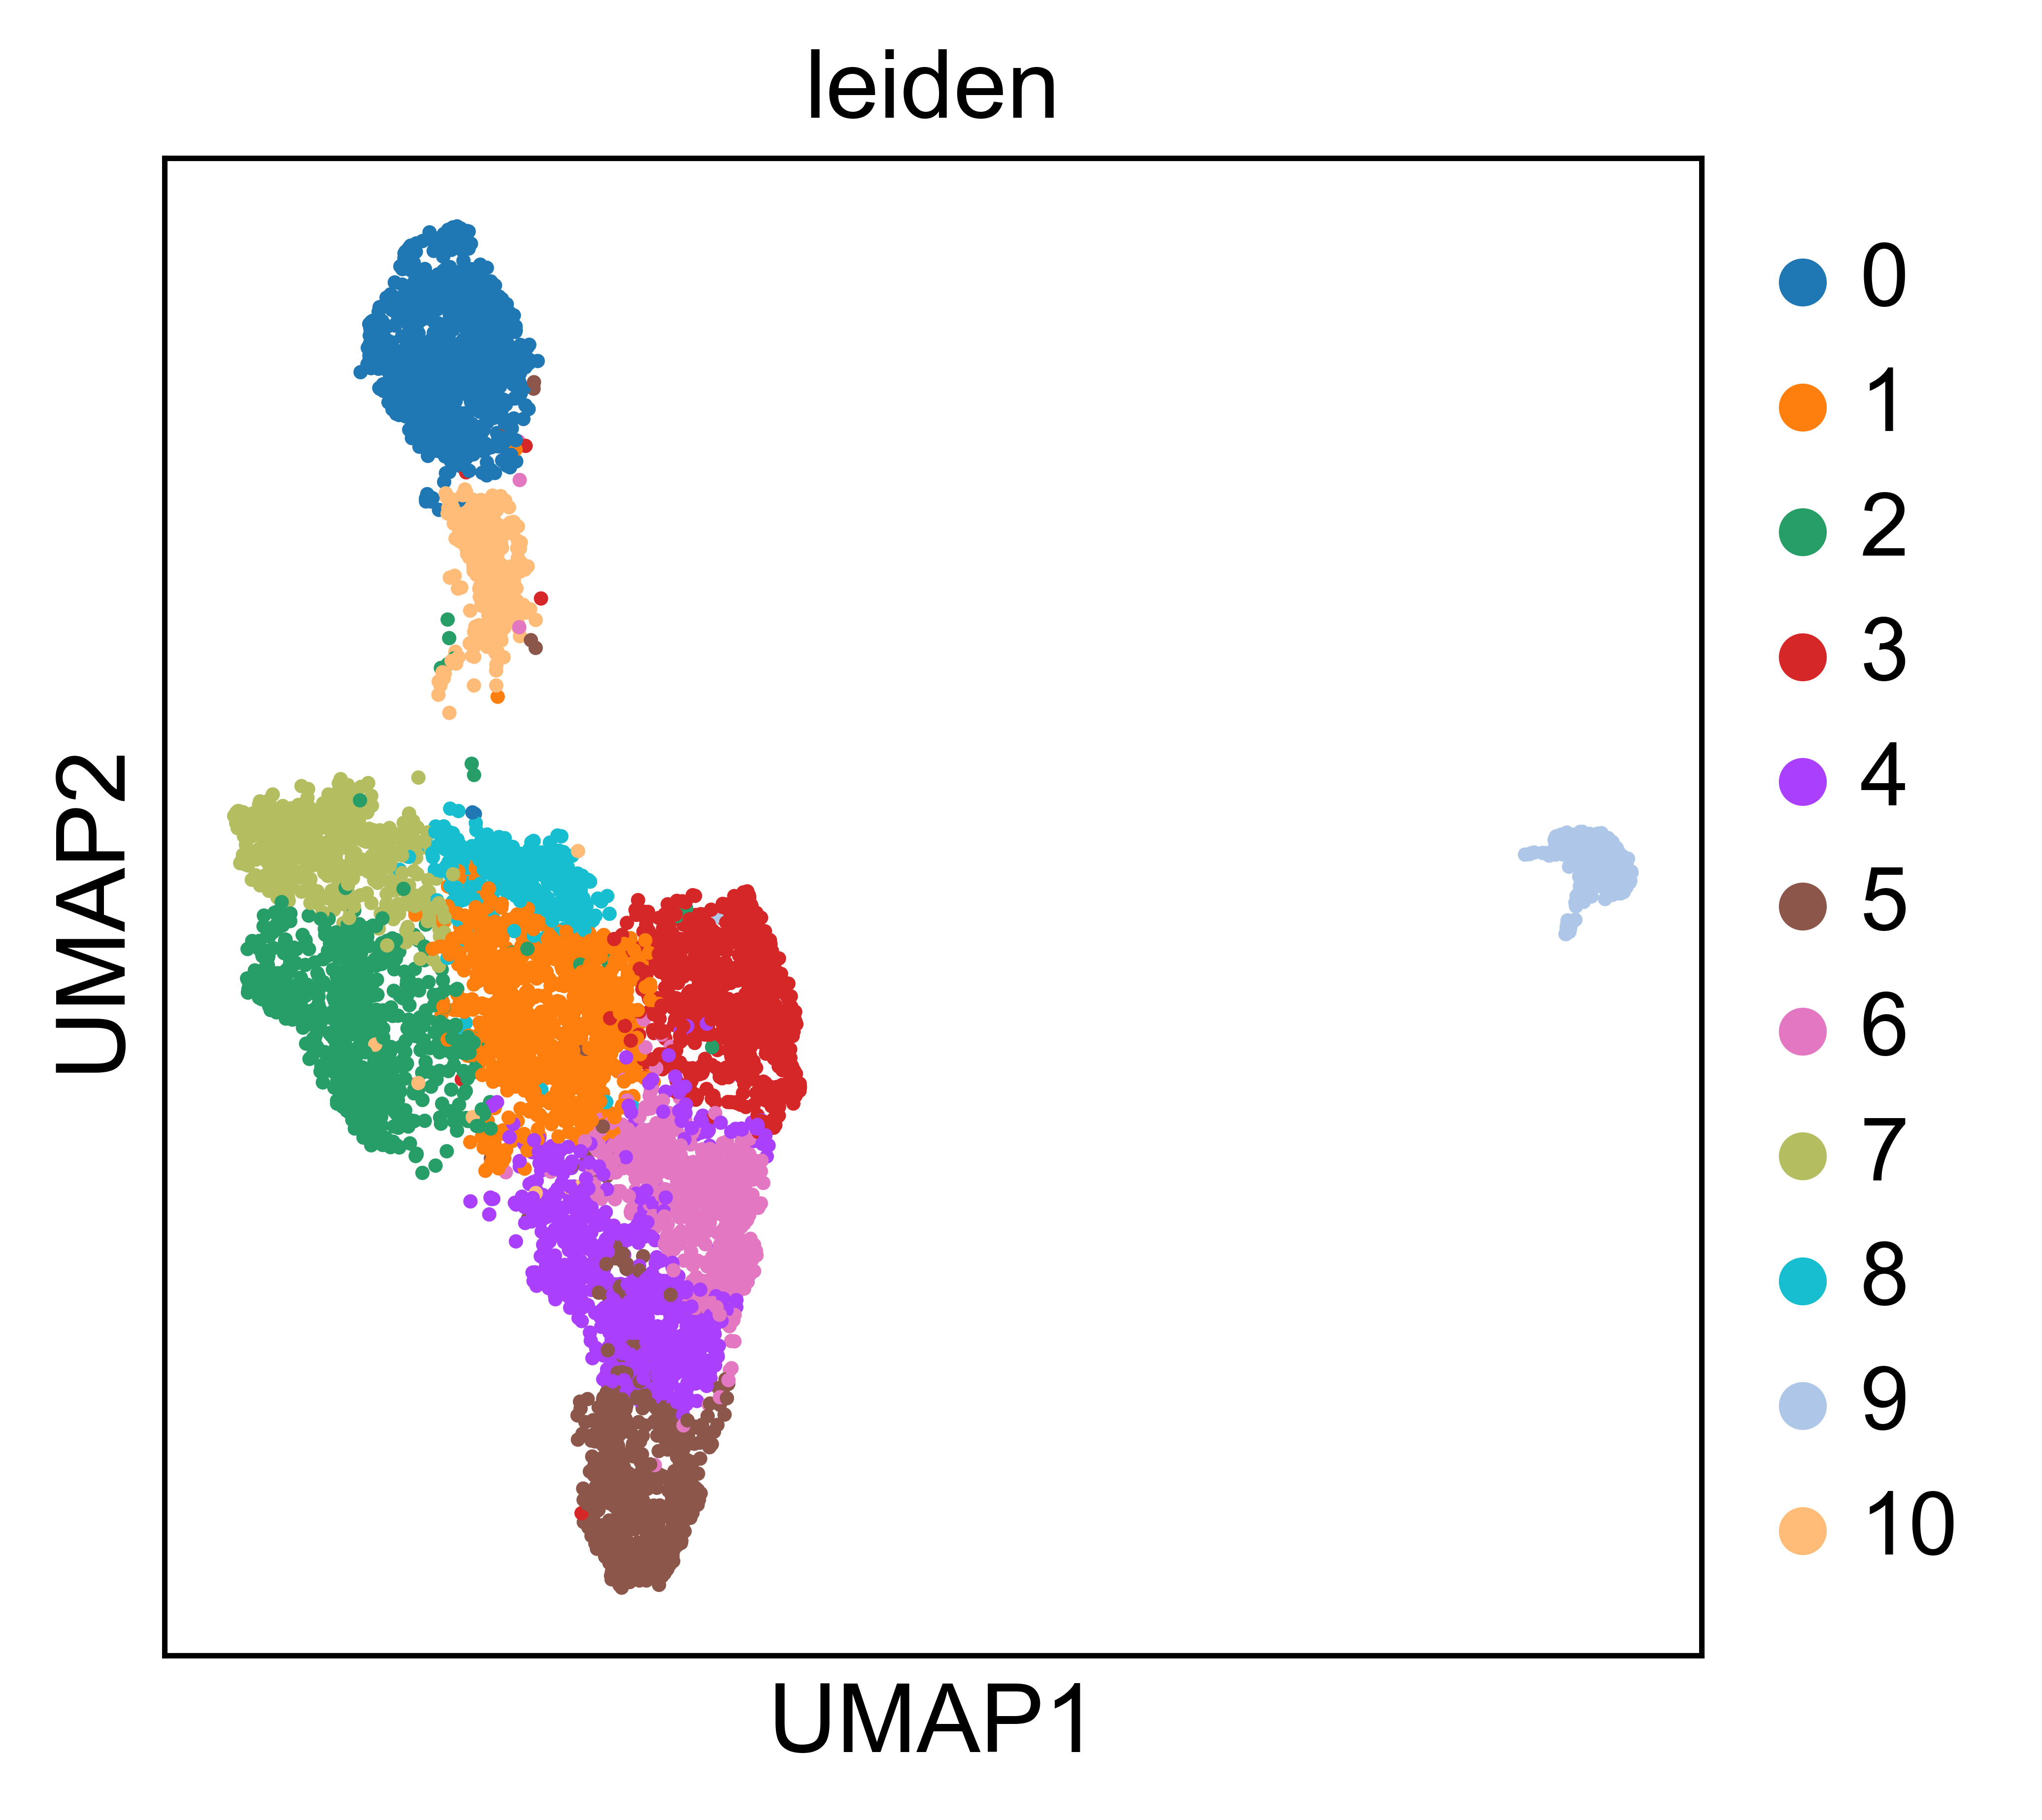

In [10]:
sc.tl.leiden(adata,resolution=1)
sc.pl.umap(adata, color = ["leiden"])

In [11]:
pd.set_option('display.max_columns', None)
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
display(pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20))


,0,1,2,3,4,5,6,7,8,9,10
0,ETS1,CSF3R,S100A9,IFIT3,LOC102119366,SLC43A3,CD83,PLBD1,LOC102122749,F5,CD74
1,FAM46C,RNF149,SELL,IFIT1,LOC102118223,BHLHE40,ICAM1,S100A9,CFD,FFAR3,LOC102144039
2,LOC102133263,RNASET2,PLBD1,IFIT2,LOC102119743,ATP13A3,MARCKS,VCAN,AIF1,PLAUR,LOC102136468
3,CD3D,CFD,VCAN,ISG15,TNF,MAP4K4,TNFAIP2,SELL,RGS2,TKT,LOC102136862
4,CALM1,LOC102126493,S100A8,HERC5,NBN,LOC102129811,SUCNR1,RGS2,TYROBP,LOC102141498,LOC102140782
5,RPS3,ZCCHC6,XPO6,MX1,FFAR2,PLAU,CTSH,LOC102139186,CSF3R,LOC101865481,LYZ
6,LOC101925857,SLC35E3,MNDA,OAS2,ICAM1,SQSTM1,TGM2,SLC11A1,FCGR2B,SAMSN1,LOC102144414
7,RPL13,SMAP2,SORL1,IFI6,NFKBIA,ICAM1,RARRES3,CAMP,ZCCHC6,ARHGDIB,rna76578
8,ZFP36L2,DOCK5,CFD,MX2,PPP1R15A,NBN,LOC102146847,SORL1,GABARAP,LOC102120083,LOC102140649
9,RPS14,TXNIP,CXCR1,OASL,SOD2,HSPA5,GBP2,CFD,LOC102126493,GPR183,LOC102141176


In [12]:
sc.pl.umap(adata, color=['CD3D', 'CD8A', 'GZMH',"SFTPB","KRT7"], vmax=3)

In [13]:
#clusters 0,10 are have significant lymphocyte contaminating mRNAs - need to remove them 
doublet_vals = ["0","10"]
doublet_ind = adata.obs.index[adata.obs['leiden'].isin(doublet_vals)]
adata_allcells.obs.loc[doublet_ind, 'Doublet'] = True

In [14]:
adata_allcells.write_h5ad("./Scanpy_H5AD/adata_CellBender_Scrublet_Srubed_for_publication.h5ad")
